In [1]:
import os
import numpy as np 
import pandas as pd
import arcpy
from arcpy import env

In [2]:
result_path = r"F:\cache_data\pre_soiltype_table\ky\autogluon\predict_csv\prediction_soiltype_tz_RandomForestEntr_20240410.csv"

In [3]:
# 读取预测结果
data = pd.read_csv(result_path,index_col=False)

In [4]:
data

,prediction_0,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6,prediction_7,prediction_8,prediction_9,...,prediction_325,prediction_326,prediction_327,prediction_328,prediction_329,prediction_330,prediction_331,prediction_332,prediction_333,prediction_334
0,110,109,110,26,110,38,68,26,109,40,...,110,110,110,110,110,3,110,110,110,26.0
1,110,109,110,110,89,110,110,109,109,43,...,110,3,110,110,110,3,110,110,110,26.0
2,110,109,110,110,110,110,95,109,110,43,...,109,3,110,110,110,3,110,38,110,26.0
3,110,109,110,15,79,113,110,109,110,46,...,110,3,110,110,110,3,110,110,110,26.0
4,110,109,110,15,79,113,95,26,110,43,...,109,3,110,110,110,3,110,110,110,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,109,110,95,110,40,110,26,98,38,26,...,3,110,110,110,3,110,110,110,26,NaN
499996,109,110,26,109,38,110,26,110,38,110,...,3,110,110,110,3,110,110,110,26,NaN
499997,109,110,26,26,110,110,26,3,38,110,...,110,110,110,110,3,110,110,110,26,NaN
499998,109,110,26,110,40,110,26,110,95,95,...,110,110,110,110,3,110,110,110,26,NaN


In [5]:
stander_path = r"D:\ArcGISProjects\workspace\shbyq\feature_raster_file\features_data_ky.gdb\DEM"

In [6]:
data.columns

Index(['prediction_0', 'prediction_1', 'prediction_2', 'prediction_3',
       'prediction_4', 'prediction_5', 'prediction_6', 'prediction_7',
       'prediction_8', 'prediction_9',
       ...
       'prediction_325', 'prediction_326', 'prediction_327', 'prediction_328',
       'prediction_329', 'prediction_330', 'prediction_331', 'prediction_332',
       'prediction_333', 'prediction_334'],
      dtype='object', length=335)

In [7]:
# 合并除第一列外的所有列到第一列
frames = []
for col in data.columns:
    frames.append(data[col])

# 合并 DataFrame
merged_data = pd.concat(frames, axis=0, ignore_index=True)

In [8]:
merged_data.dropna(inplace=True)

In [9]:
merged_data.size

167330638

In [10]:
merged_data.value_counts()

110.0    77043856
3.0      17384575
109.0    14660834
113.0     7193026
26.0      6073221
           ...   
111.0        8293
102.0        8090
25.0         6083
105.0        3491
103.0        1853
Length: 92, dtype: int64

In [11]:

# def label_array(mixed_array):
#     # 获取唯一的值
#     unique_values = list(set(merged_data.values))

#     # 创建一个字典来映射唯一值到标签
#     label_mapping = {value: index for index, value in enumerate(unique_values)}

#     # 使用字典映射函数将数组标签化
#     labeled_array = np.vectorize(label_mapping.get)(mixed_array)
#     return labeled_array,label_mapping
# # 标签化array
# cach_result = label_array(merged_data)

In [12]:
type(merged_data)

pandas.core.series.Series

In [13]:
dem_array = arcpy.RasterToNumPyArray(stander_path)
dem_array.shape

(13978, 11971)

In [14]:
dem_array.shape[0] * dem_array.shape[1]

167330638

In [15]:
raster_array = np.reshape(merged_data.values,dem_array.shape)

In [16]:
raster_array = raster_array.astype(np.float32)

In [17]:
dem_array.dtype,raster_array.dtype

(dtype('float32'), dtype('float32'))

In [18]:
env.workspace = r"D:\ArcGISProjects\workspace\shbyq\feature_soiltype_result\feature_soiltype_result_ky.gdb"
env.extent = stander_path

In [19]:
# 掩膜提取
def mask_raster(array,mask_ele,cell_size):
    out_raster = arcpy.NumPyArrayToRaster(
    array,
    arcpy.Point(arcpy.env.extent.XMin, arcpy.env.extent.YMin),
    cell_size,
    cell_size,
)
    """按掩膜提取栅格,空间参考设定为:CGCS2000_3_Degree_GK_CM_108E"""
    output_coordinate_system = arcpy.Describe(mask_ele).spatialReference
    with arcpy.EnvManager(outputCoordinateSystem=output_coordinate_system,snapRaster=mask_ele, cellSize=mask_ele):
        result_raster = arcpy.sa.ExtractByMask(out_raster, mask_ele, "INSIDE")
        return result_raster

In [20]:
# 按掩膜处理
result_raster = mask_raster(raster_array,stander_path, 5)
# result_raster.save("prediction_sioltype_CATB_20240226")
print("完成")

完成


In [21]:
# 按掩膜分割
# 按掩膜提取
def mask_extraction(in_raster,mask_ele,pro_ele):
    ele_pro = arcpy.Describe(pro_ele).spatialReference
    with arcpy.EnvManager(outputCoordinateSystem=ele_pro,snapRaster=pro_ele, cellSize=5):
        out_raster = arcpy.sa.ExtractByMask(in_raster, mask_ele, "INSIDE", ele_pro)
        return out_raster
mask_ele = r"D:\ArcGISProjects\workspace\shbyq\features_data_vector.gdb\extent\KY"
clip_raster = mask_extraction(result_raster,mask_ele,result_raster)
clip_raster.save("prediction_soiltype_tz_RFE_20240411")

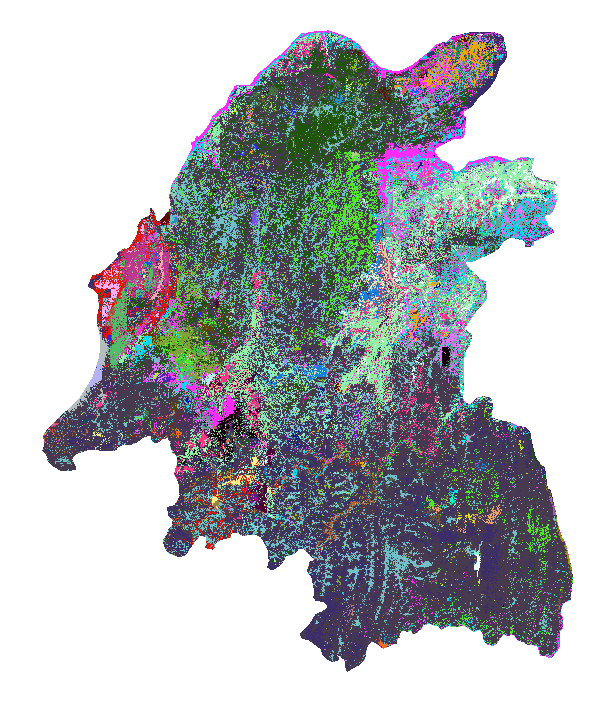

In [22]:
arcpy.sa.Int(clip_raster)

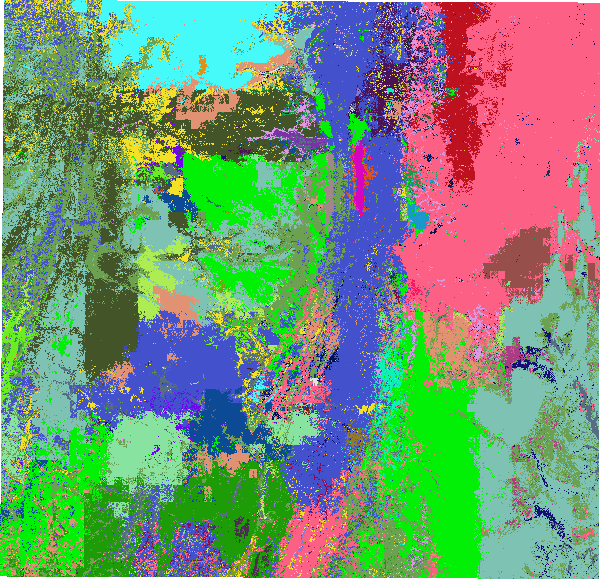

In [17]:
arcpy.sa.Int(result_raster)

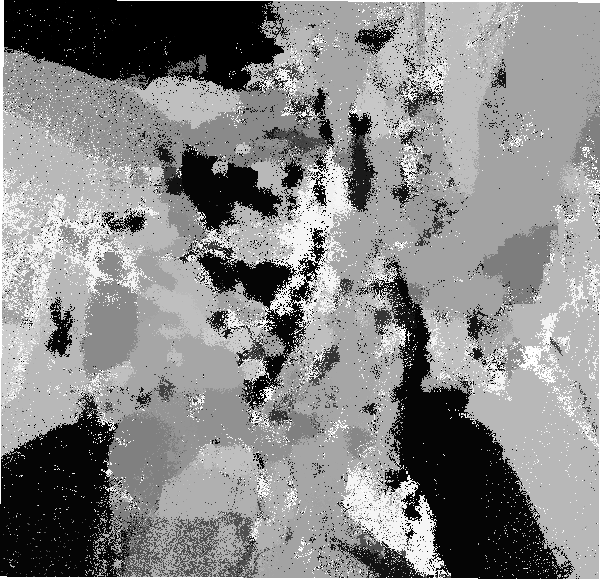

In [37]:
result_raster

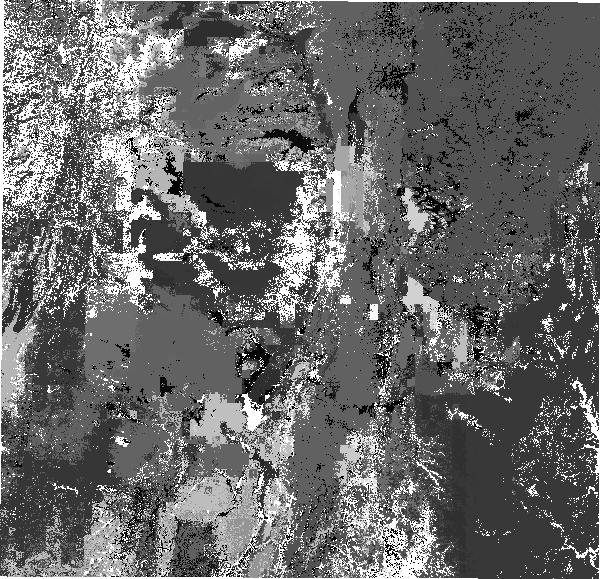

In [18]:
result_raster

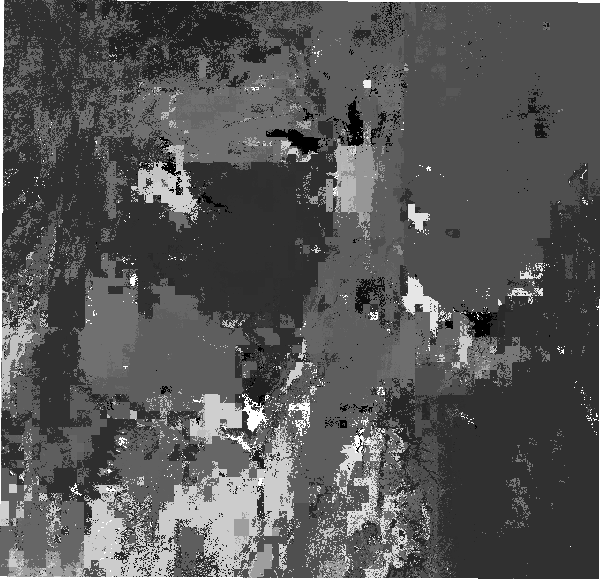

In [19]:
result_raster